Wczytanie rastra wielokanałowego CIR:

In [858]:
from osgeo import gdal
gdal.UseExceptions()
from typing import Union
from pathlib import Path
import numpy as np

def read_spatial_raster(path: Union[str, Path]) -> gdal.Dataset:
    dataset = gdal.Open(str(path))
    assert dataset is not None, "Read spatial raster returned None"
    return dataset

raster_file_CIR = "CIR2023.tif"
raster_file_RGB = "RGB2023.tif"
raster_file_CIR_2015 = "CIR2015.tif"    
raster_file_RGB_2015 = "RGB2015.tif"

raster_dataset_CIR = read_spatial_raster(raster_file_CIR)
raster_dataset_RGB = read_spatial_raster(raster_file_RGB)
raster_dataset_CIR_2015 = read_spatial_raster(raster_file_CIR_2015)
raster_dataset_RGB_2015 = read_spatial_raster(raster_file_RGB_2015)

c:\Users\mplaciszewska\anaconda3\envs\teledetekcja2\Lib\site-packages\osgeo\gdal.py:8817: RuntimeWarning: CIR2015.tif: JPEGFixupTagsSubsamplingSec:Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [1,1]
  return _gdal.Open(*args)
c:\Users\mplaciszewska\anaconda3\envs\teledetekcja2\Lib\site-packages\osgeo\gdal.py:8817: RuntimeWarning: RGB2015.tif: JPEGFixupTagsSubsamplingSec:Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [1,1]
  return _gdal.Open(*args)


Wizualizacja kanałów rastra w matplotlib:

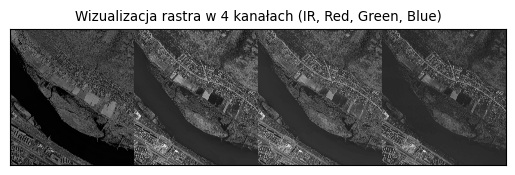

In [859]:
import matplotlib.pyplot as plt

def read_raster_band(dataset: gdal.Dataset, band_number: int) -> gdal.Band:
    assert 0 < band_number <= dataset.RasterCount, f"Band number {band_number} is invalid for raster with {dataset.RasterCount} bands."
    band = dataset.GetRasterBand(band_number)
    assert band is not None, f"Unable to read band {band_number}"
    return band

def read_band_as_array(band: gdal.Band) -> np.ndarray:
    array = band.ReadAsArray()
    array = np.copy(array)  # To make sure we do not get memory errors
    return array

def process_year(raster_dataset_CIR, raster_dataset_RGB):
    nir_band = read_raster_band(raster_dataset_CIR, 1)
    nir_array = read_band_as_array(nir_band)

    red_band = read_raster_band(raster_dataset_CIR, 2)
    red_array = read_band_as_array(red_band)

    green_band = read_raster_band(raster_dataset_CIR, 3)
    green_array = read_band_as_array(green_band)

    blue_band = read_raster_band(raster_dataset_RGB, 3)
    blue_array = read_band_as_array(blue_band)

    return nir_array, red_array, green_array, blue_array

nir_array, red_array, green_array, blue_array = process_year(raster_dataset_CIR, raster_dataset_RGB)

#wizualizacja 4 kanalow na calym rastrze
rgb_h = np.hstack((nir_array, red_array, green_array, blue_array))
plt.imshow(rgb_h, cmap='gray')
plt.title("Wizualizacja rastra w 4 kanałach (IR, Red, Green, Blue)")
plt.xticks([])
plt.yticks([])
plt.show()

Wczytanie danych wektorowych (dróg), transformacja z układu natywnego do układu pikselowego

In [860]:
from typing import Tuple, List
import geopandas as gpd
import pandas as pd
import shapely

def points_to_pixels(points: np.ndarray, geotransform: List[float]) -> np.ndarray:
    c, a, _, f, _, e = geotransform
    columns = (points[:, 0] - c) / a
    rows = (points[:, 1] - f) / e
    pixels = np.vstack([rows, columns])
    pixels = pixels.T
    return pixels

def read_features_to_geopandas(path: Union[str, Path]) -> gpd.GeoDataFrame:
    features = gpd.read_file(path)
    return features

def reproject_geodataframe(features: gpd.GeoDataFrame, crs: str) -> gpd.GeoDataFrame:
    return features.to_crs(crs)

def convert_to_pixel_system(features: gpd.GeoDataFrame, geotransform: List[float]) -> gpd.GeoDataFrame:
    def transform_function(xy: np.ndarray):
        ij = points_to_pixels(xy, geotransform)
        ji = ij[:, [1, 0]]
        return ji
    
    indices = features.index
    for i in indices:
        geometry = features.loc[i, "geometry"]
        geometry = shapely.transform(geometry, transform_function)  # To make our solution work for every type of geometry
        features.loc[i, "geometry"] = geometry
    return features
    
features_file = "drogi.shp"
features = read_features_to_geopandas(features_file)
features = reproject_geodataframe(features, raster_dataset_CIR.GetProjection())
features = convert_to_pixel_system(features, raster_dataset_CIR.GetGeoTransform())

Wycięcie mniejszego fragmentu rastra w obrębie kilku wybranych poligonów:

In [861]:
chosen_features= []
chosen_polygons = []

bounds_list = []
nir_fragments = []
red_fragments = []
green_fragments = []
blue_fragments = []

chosen_features.append(features.iloc[1])
chosen_features.append(features.iloc[2])
chosen_features.append(features.iloc[9])
chosen_features.append(features.iloc[8])

def clip_to_feature(example_polygon):
    bounds = example_polygon.bounds
    bounds = np.float64(bounds)
    # print("BBOX poligonu:", bounds)

    bounds[:2] = np.floor(bounds[:2])
    bounds[2:] = np.ceil(bounds[2:])
    bounds = np.int64(bounds)
    # print("BBOX poligonu (integer):", bounds)
    return bounds

def clip_array(bounds, array):
    fragment = array[
        bounds[1]: bounds[3],
        bounds[0]: bounds[2]
    ]
    return fragment

for i in range(len(chosen_features)):
    chosen_polygons.append(chosen_features[i]["geometry"])
    bounds = clip_to_feature(chosen_polygons[i])
    bounds_list.append(bounds)
    nir_fragments.append(clip_array(bounds, nir_array))
    red_fragments.append(clip_array(bounds, red_array))
    green_fragments.append(clip_array(bounds, green_array))
    blue_fragments.append(clip_array(bounds, blue_array))


Maskowanie pikseli położonych w obrębie wyciętego fragmentu rastra (BBOX), ale poza wybranym poligonem i wizualizacja wybranych poligonów w każdym z kanałów spektralnych.

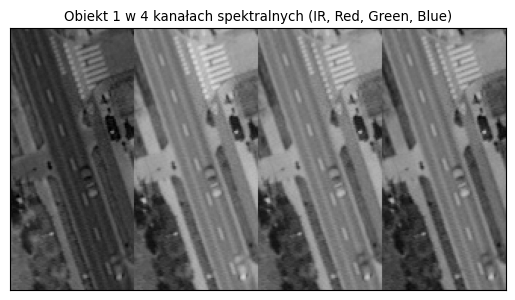

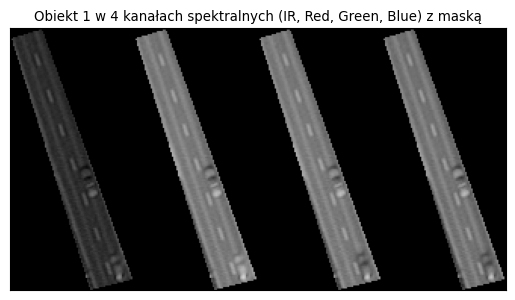

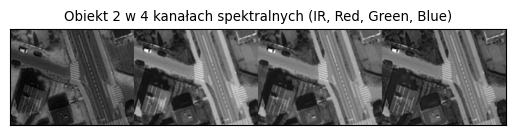

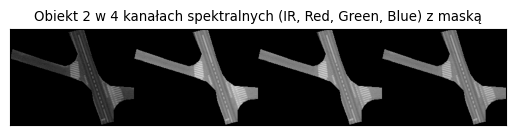

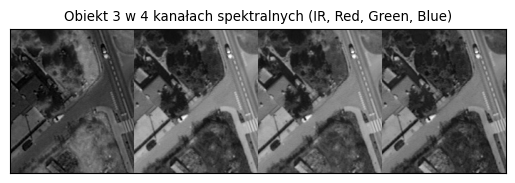

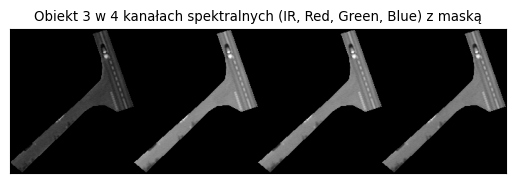

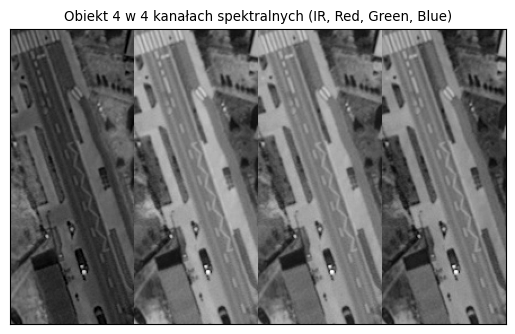

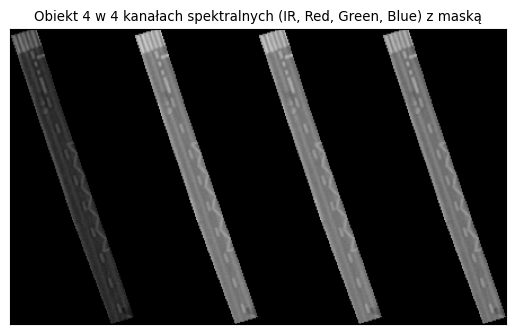

In [862]:
from rasterio.features import rasterize

def plot_object_in_channels(nir, red, green, blue):
    channels_stack = np.hstack((nir, red, green, blue))
    plt.imshow(channels_stack, cmap='gray', vmin=0, vmax=255)
    plt.rcParams.update({'font.size': 8})
    plt.xticks([])
    plt.yticks([])
   
nir_masked_list = []
red_masked_list = []
green_masked_list = []
blue_masked_list = []

def mask_fragment(fragment, polygon_in_fragment_frame):
    no_data_mask = rasterize([polygon_in_fragment_frame], fragment.shape)
    no_data_mask = np.bool_(no_data_mask)
    no_data_mask = ~no_data_mask    # Rasterio puts True inside polygon
    masked_fragment = np.copy(fragment)
    masked_fragment[no_data_mask] = 0
    return masked_fragment, no_data_mask

for i in range(len(chosen_polygons)):
    polygon_in_fragment_frame = shapely.affinity.translate(chosen_polygons[i], -bounds_list[i][0], -bounds_list[i][1])
    nir_masked, nir_no_data_mask = mask_fragment(nir_fragments[i], polygon_in_fragment_frame)
    red_masked, red_no_data_masked = mask_fragment(red_fragments[i], polygon_in_fragment_frame)
    green_masked, green_no_data_masked = mask_fragment(green_fragments[i], polygon_in_fragment_frame)
    blue_masked, blue_no_data_masked = mask_fragment(blue_fragments[i], polygon_in_fragment_frame)
    nir_masked_list.append((nir_masked, nir_no_data_mask))
    red_masked_list.append((red_masked, red_no_data_masked))
    green_masked_list.append((green_masked, green_no_data_masked))
    blue_masked_list.append((blue_masked, blue_no_data_masked))
    plot_object_in_channels(nir_fragments[i], red_fragments[i], green_fragments[i], blue_fragments[i])
    plt.title(f"Obiekt {i + 1} w 4 kanałach spektralnych (IR, Red, Green, Blue)")
    plt.show()
    plot_object_in_channels(nir_masked, red_masked, green_masked, blue_masked)
    plt.title(f"Obiekt {i + 1} w 4 kanałach spektralnych (IR, Red, Green, Blue) z maską")
    plt.show()
    

Zestawienie wybranych statystyk numerycznych w poszczególnych kanałach obrazu

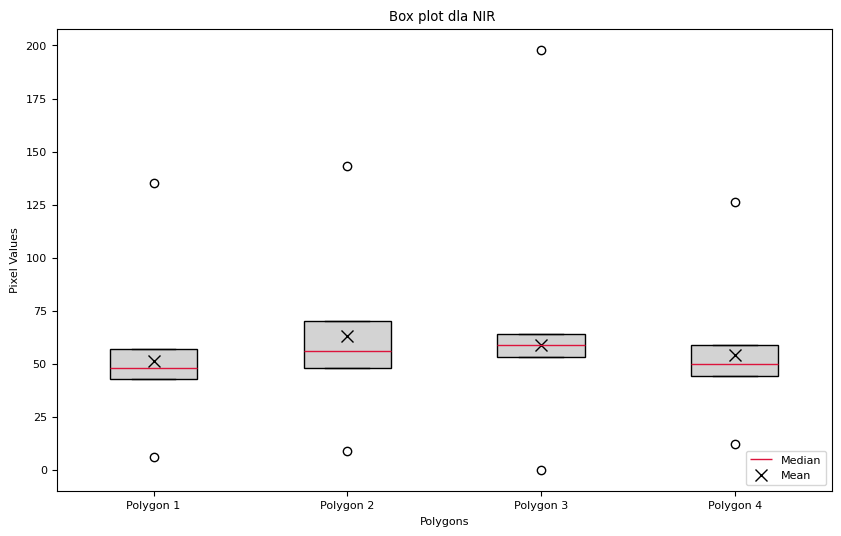

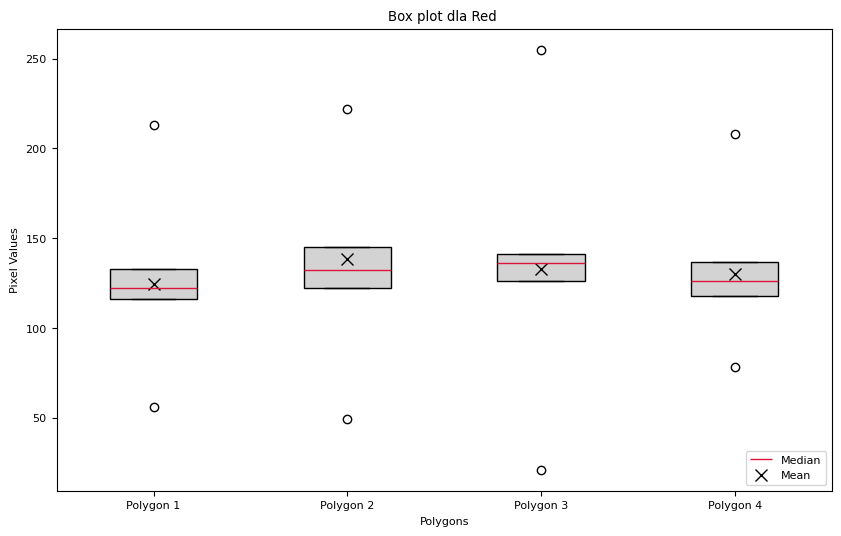

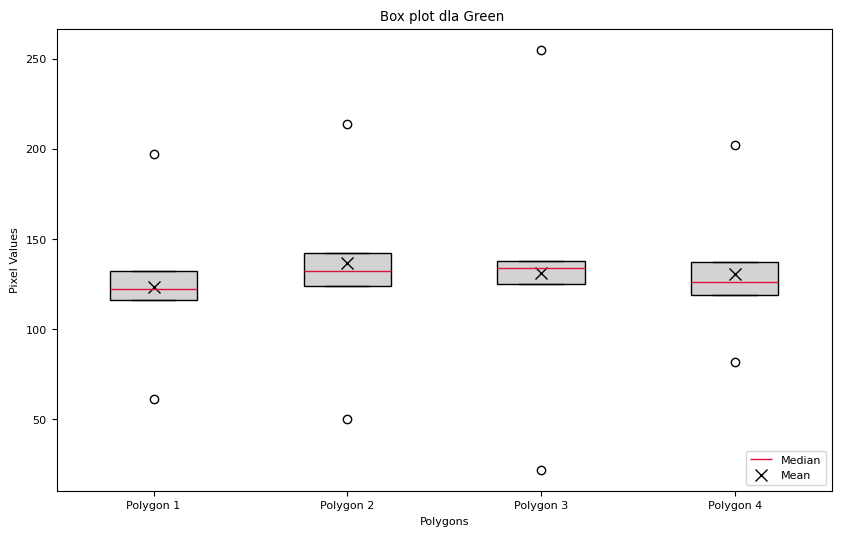

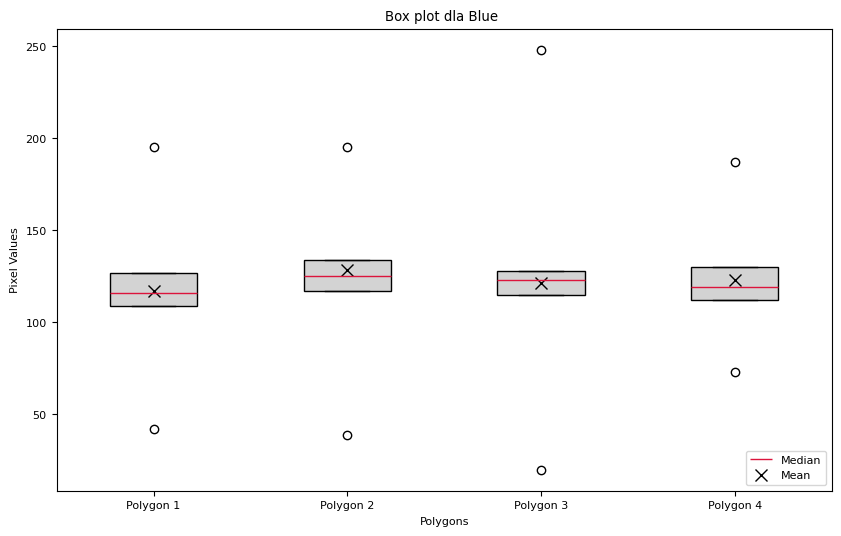

In [863]:
nir_statistics = []
red_statistics = []
green_statistics = []
blue_statistics = []

def calc_statistics(fragment, no_data_mask=None):
    if no_data_mask is None:
        no_data_mask = fragment == 0
    pixel_values = fragment[~no_data_mask] # Select just valid pixels
    # calculate quartiles
    q1 = np.percentile(pixel_values, 25)
    median = np.percentile(pixel_values, 50)
    q3 = np.percentile(pixel_values, 75)
    return  pixel_values.min(), q1, median, q3, pixel_values.max(), pixel_values.mean()

for i in range(len(chosen_polygons)):
    nir_statistics.append(calc_statistics(nir_masked_list[i][0], nir_masked_list[i][1]))
    red_statistics.append(calc_statistics(red_masked_list[i][0], red_masked_list[i][1]))
    green_statistics.append(calc_statistics(green_masked_list[i][0], green_masked_list[i][1]))
    blue_statistics.append(calc_statistics(blue_masked_list[i][0], blue_masked_list[i][1]))

nir_statistics = np.array(nir_statistics)
red_statistics = np.array(red_statistics)
green_statistics = np.array(green_statistics)
blue_statistics = np.array(blue_statistics)

def plot_boxplot(statistics, channel_name, year=""):
    fig, ax = plt.subplots(figsize=(10, 6))
    statistics_plot = statistics [:, :5]
    
    # transpose the data to group by polygon
    data_by_polygon = statistics_plot.T
    data_by_polygon_mean = statistics.T

    # create a boxplot for each polygon's statistics
    boxplot = ax.boxplot(data_by_polygon, tick_labels=[f'Polygon {i+1}' for i in range(statistics_plot.shape[0])], patch_artist=True, boxprops=dict(facecolor='lightgray'), medianprops=dict(color='crimson'))
    for i, mean in enumerate(data_by_polygon_mean[5]):
        ax.plot(i+1, mean, 'x', markersize=8, markeredgewidth=1, color = 'black')

    ax.legend([boxplot["medians"][0], ax.plot([], [], 'x', markersize=8, markeredgewidth=1, color='black')[0]], ['Median', 'Mean'], loc='lower right')
    ax.set_ylabel('Pixel Values')
    ax.set_xlabel('Polygons')
    ax.set_title(f"Box plot dla {channel_name} {year}")
    plt.show()

plot_boxplot(nir_statistics, 'NIR')
plot_boxplot(red_statistics, 'Red')
plot_boxplot(green_statistics, 'Green')
plot_boxplot(blue_statistics, 'Blue')

Porównanie wyglądu obiektów na wybranych kompozycjach barwnych.

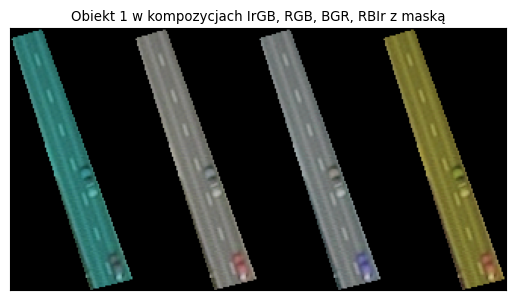

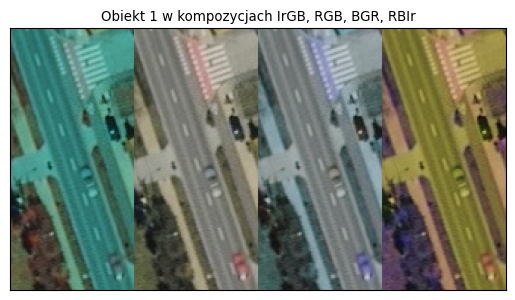

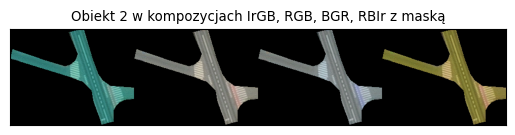

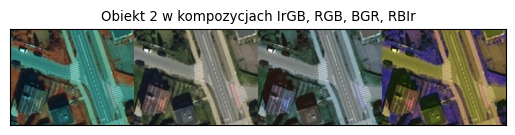

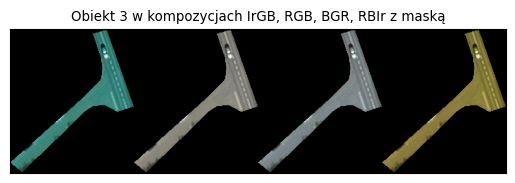

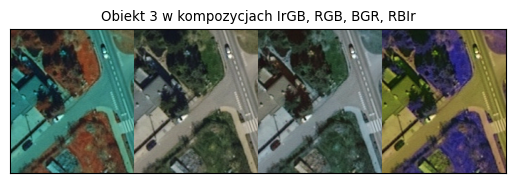

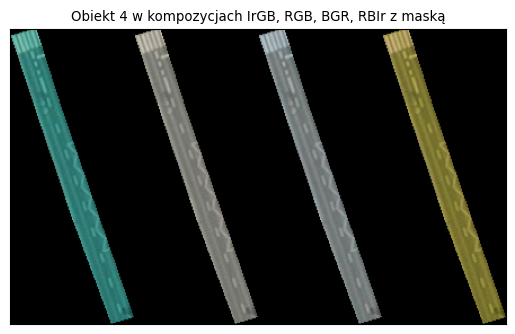

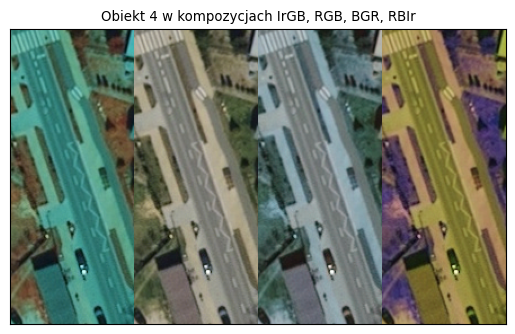

In [864]:
def create_composition(channel1, channel2, channel3):
    composition = np.dstack((channel1, channel2, channel3))
    plt.imshow(composition)
    plt.xticks([])
    plt.yticks([])
    return composition

def plot_object_in_composition(nir, red, green, blue):
    composition1 = create_composition(nir, green, blue)
    composition2 = create_composition(red, green, blue)
    composition3 = create_composition(blue, green, red)
    composition4 = create_composition(red, blue, nir)
    composition_hstack = np.hstack((composition1, composition2, composition3, composition4))
    plt.imshow(composition_hstack)
    return composition_hstack

for i in range(len(chosen_polygons)):
    composition_masked = plot_object_in_composition(nir_masked_list[i][0], red_masked_list[i][0], green_masked_list[i][0], blue_masked_list[i][0])
    plt.title(f"Obiekt {i + 1} w kompozycjach IrGB, RGB, BGR, RBIr z maską")
    plt.show()
    composition_unmasked = plot_object_in_composition(nir_fragments[i], red_fragments[i], green_fragments[i], blue_fragments[i])
    plt.title(f"Obiekt {i + 1} w kompozycjach IrGB, RGB, BGR, RBIr")
    plt.show()

Wyznaczenie wskaźnika NDVI - Normalized Difference Vegetation Index i TNDVI - Transformed Normalized Difference Vegetation Index

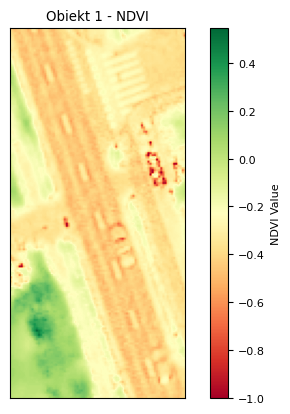

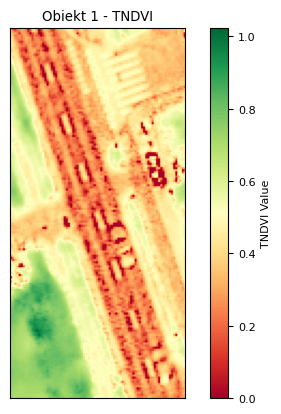

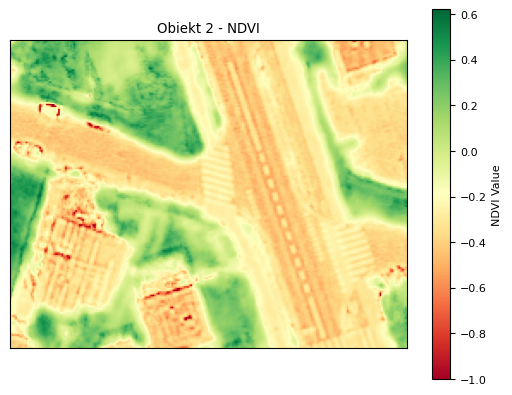

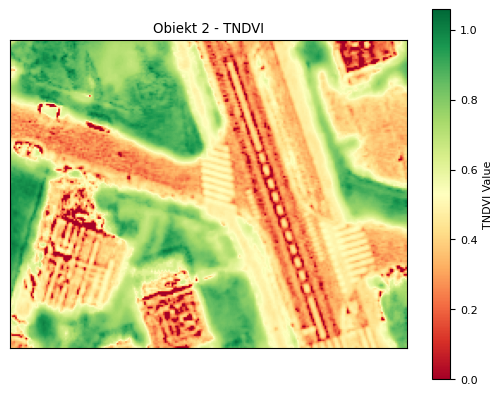

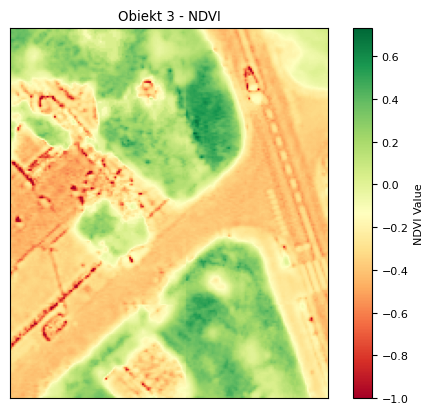

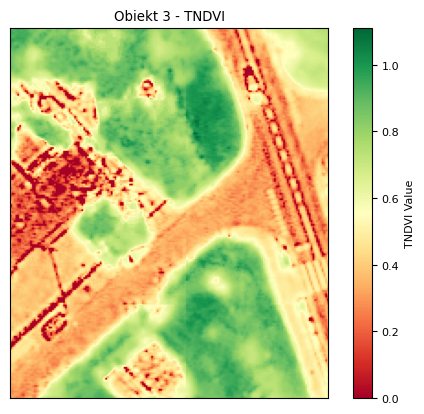

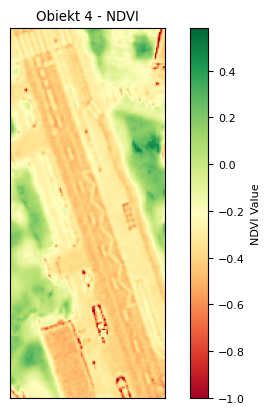

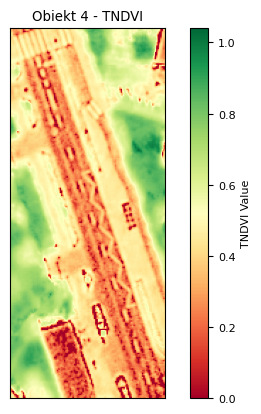

In [867]:
def calculate_NDVI(nir_array, red_array):
    IR = np.float32(nir_array)
    R = np.float32(red_array)
    NDVI = (IR-R)/(IR+R)
    NDVI[np.isnan(NDVI)] = 0
    return NDVI

#TNDVI - This index is useful for monitoring vegetation cover in urban environments. It does not saturate like NDVI
def calculate_TNDVI (nir_array, red_array):
    IR = np.float32(nir_array)
    R = np.float32(red_array)
    TNDVI = ((IR - R) / (IR + R) + 0.5)
    # Clip any negative values to 0 (to avoid issues with the square root)
    TNDVI = np.maximum(TNDVI, 0)
    # Now apply the square root
    TNDVI = np.sqrt(TNDVI)
    TNDVI[np.isnan(TNDVI)] = 0
    return TNDVI

NDVI_masked_list = []
TNDVI_masked_list = []

for i in range (len(chosen_polygons)):
    fragmentNDVI = calculate_NDVI(nir_fragments[i], red_fragments[i])
    plt.imshow(fragmentNDVI, cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.set_label("NDVI Value")
    plt.title(f"Obiekt {i + 1} - NDVI")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    fragmentTNDVI = calculate_TNDVI(nir_fragments[i], red_fragments[i])
    plt.imshow(fragmentTNDVI, cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.set_label("TNDVI Value")
    plt.title(f"Obiekt {i + 1} - TNDVI")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    polygon_in_fragment_frame = shapely.affinity.translate(chosen_polygons[i], -bounds_list[i][0], -bounds_list[i][1])

    fragment_NDVI_masked, NDVI_no_data_mask = mask_fragment(fragmentNDVI, polygon_in_fragment_frame)
    NDVI_masked_list.append((fragment_NDVI_masked, NDVI_no_data_mask))

    fragmentTNDVI_masked, TNDVI_no_data_mask = mask_fragment(fragmentTNDVI, polygon_in_fragment_frame)
    TNDVI_masked_list.append((fragmentTNDVI_masked, TNDVI_no_data_mask))

Zestawienie dla wskaźników spektralnych wartości statystycznych

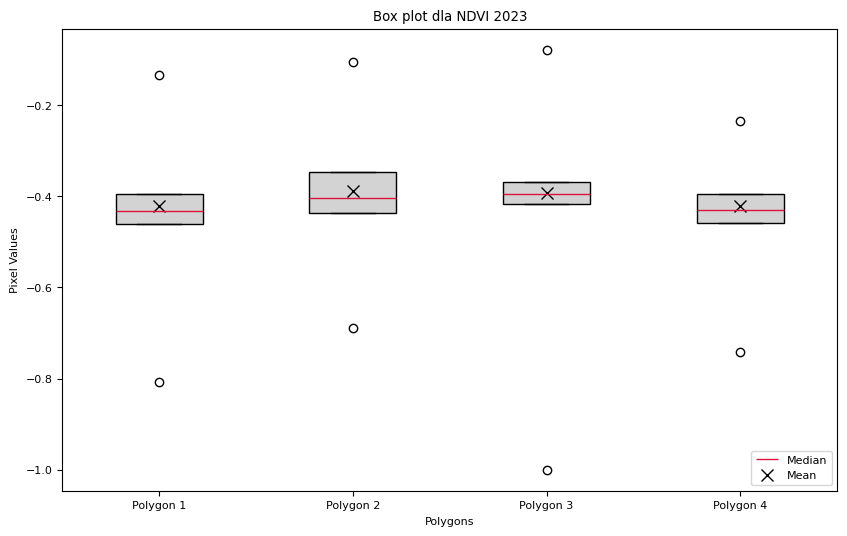

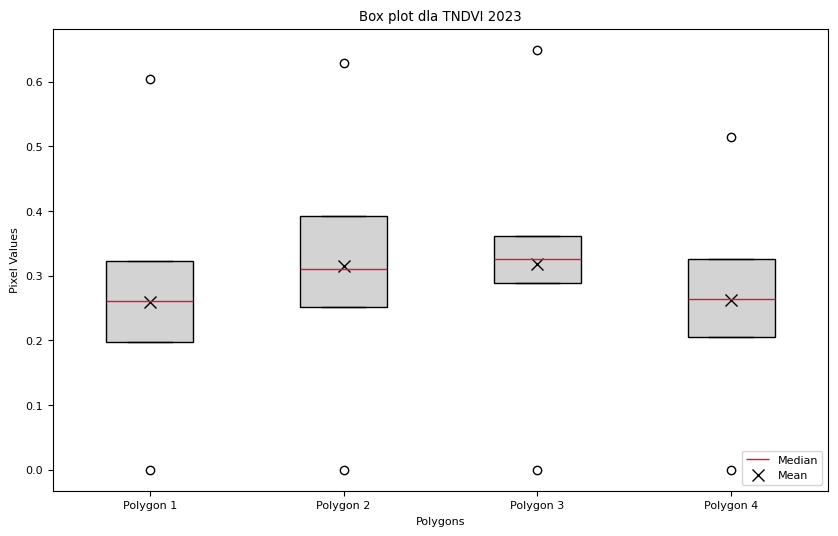

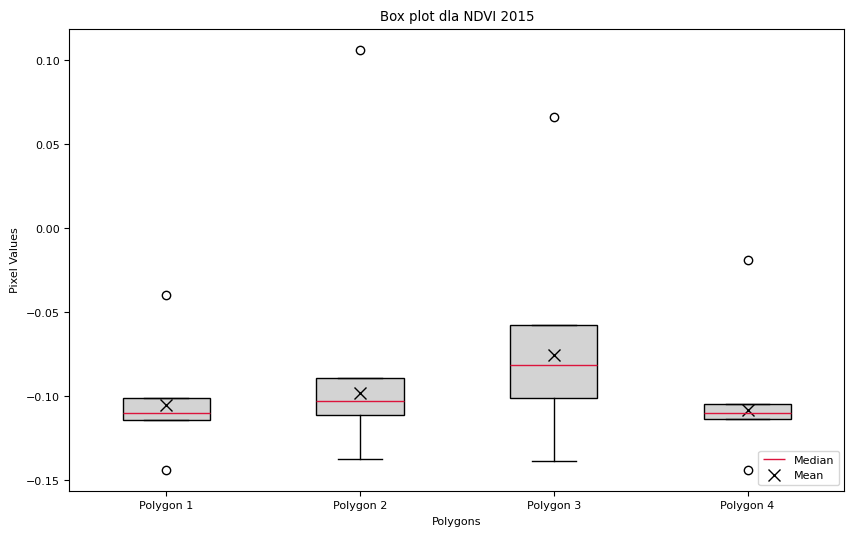

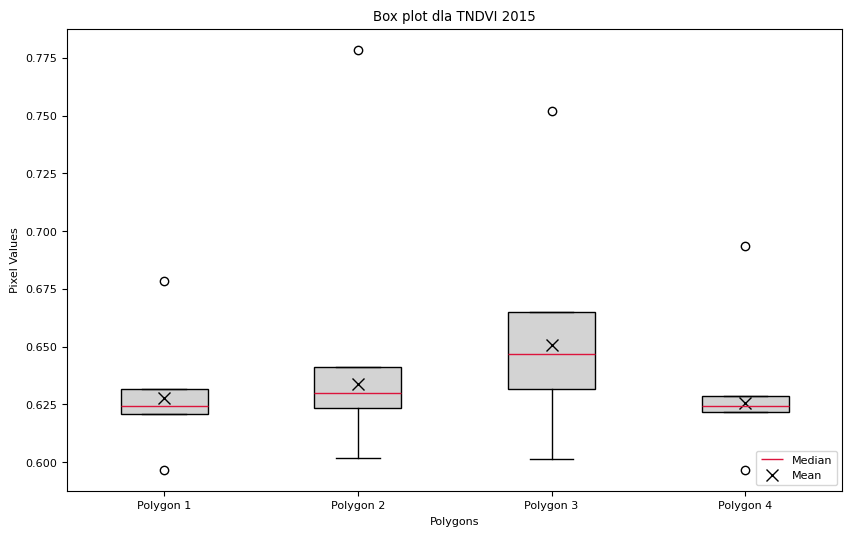

In [868]:
NDVI_statistics_2023 = []
TNDVI_statistics_2023 = []

for i in range(len(chosen_polygons)):
    NDVI_statistics_2023.append(calc_statistics(NDVI_masked_list[i][0], NDVI_masked_list[i][1]))
    TNDVI_statistics_2023.append(calc_statistics(TNDVI_masked_list[i][0], TNDVI_masked_list[i][1]))

NDVI_statistics_2023 = np.array(NDVI_statistics_2023)
TNDVI_statistics_2023 = np.array(TNDVI_statistics_2023)

plot_boxplot(NDVI_statistics_2023, 'NDVI', "2023")
plot_boxplot(TNDVI_statistics_2023, 'TNDVI', "2023")

nir_array_2015, red_array_2015, _, _ = process_year(raster_dataset_CIR_2015, raster_dataset_RGB_2015)

nir_fragments_2015 = []
red_fragments_2015 = []
NDVI_masked_list_2015 = []
TNDVI_masked_list_2015 = []

for i in range(len(chosen_polygons)):
    bounds = clip_to_feature(chosen_polygons[i])
    bounds_list.append(bounds)
    nir_fragments_2015.append(clip_array(bounds, nir_array_2015))
    red_fragments_2015.append(clip_array(bounds, red_array_2015))

for i in range(len(chosen_polygons)):
    fragmentNDVI = calculate_NDVI(nir_fragments_2015[i], red_fragments_2015[i])
    polygon_in_fragment_frame = shapely.affinity.translate(chosen_polygons[i], -bounds_list[i][0], -bounds_list[i][1])
    fragment_NDVI_masked, NDVI_no_data_mask = mask_fragment(fragmentNDVI, polygon_in_fragment_frame)
    NDVI_masked_list_2015.append((fragment_NDVI_masked, NDVI_no_data_mask))

    fragmentTNDVI = calculate_TNDVI(nir_fragments_2015[i], red_fragments_2015[i])
    fragmentTNDVI_masked, TNDVI_no_data_mask = mask_fragment(fragmentTNDVI, polygon_in_fragment_frame)
    TNDVI_masked_list_2015.append((fragmentTNDVI_masked, TNDVI_no_data_mask))

NDVI_statistics_2015 = []
TNDVI_statistics_2015 = []

for i in range(len(chosen_polygons)):
    NDVI_statistics_2015.append(calc_statistics(NDVI_masked_list_2015[i][0], NDVI_masked_list_2015[i][1]))
    TNDVI_statistics_2015.append(calc_statistics(TNDVI_masked_list_2015[i][0], TNDVI_masked_list_2015[i][1]))

NDVI_statistics_2015 = np.array(NDVI_statistics_2015)
TNDVI_statistics_2015 = np.array(TNDVI_statistics_2015)

plot_boxplot(NDVI_statistics_2015, 'NDVI', "2015")
plot_boxplot(TNDVI_statistics_2015, 'TNDVI', "2015")
